# Network Anomaly Detection

This notebook demonstrates unsupervised anomaly detection on telecom network KPI data
using Isolation Forest. We identify anomalous cell behavior from time-series metrics
and evaluate detection quality against ground-truth labels.

## 1. Setup & Configuration

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
sns.set_palette("husl")

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

In [2]:
import sys
sys.path.insert(0, "../src")

RANDOM_STATE = 42
DATA_PATH = "../data/raw/anomaly_detection_raw.parquet"

np.random.seed(RANDOM_STATE)
print("Environment ready.")

Environment ready.


## 2. Data Loading & Validation

In [3]:
df = pd.read_parquet(DATA_PATH)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (36000, 13)
Columns: ['cell_id', 'cell_type', 'area_type', 'timestamp', 'traffic_load_gb', 'avg_sinr_db', 'avg_throughput_mbps', 'avg_latency_ms', 'packet_loss_pct', 'connected_users', 'prb_utilization', 'label_anomaly', 'anomaly_type']


,cell_id,cell_type,area_type,timestamp,traffic_load_gb,avg_sinr_db,avg_throughput_mbps,avg_latency_ms,packet_loss_pct,connected_users,prb_utilization,label_anomaly,anomaly_type
0,CELL_0000,small,urban,2024-01-01 00:00:00,3.166556,4.278941,14.021683,22.592645,0.053849,50,0.291649,0,<NA>
1,CELL_0000,small,urban,2024-01-01 01:00:00,2.068169,14.065475,47.020030,24.239901,0.313087,50,0.257246,0,<NA>
2,CELL_0000,small,urban,2024-01-01 02:00:00,2.663578,6.956401,27.325802,24.779480,0.319210,50,0.159232,0,<NA>
3,CELL_0000,small,urban,2024-01-01 03:00:00,4.681469,11.359690,198.284672,35.213466,0.118063,50,0.214105,0,<NA>
4,CELL_0000,small,urban,2024-01-01 04:00:00,2.791156,8.947822,189.794372,24.632216,1.034568,50,0.219751,0,<NA>


In [4]:
# Anomaly rate in ground-truth labels
anomaly_col = [c for c in df.columns if 'anomaly' in c.lower() or 'label' in c.lower()][0]
print(f"Label column: {anomaly_col}")
print(f"\nAnomaly rate:")
print(df[anomaly_col].value_counts(normalize=True).round(4))
print(f"\nAnomaly count: {df[anomaly_col].sum()} / {len(df)}")

Label column: label_anomaly

Anomaly rate:
label_anomaly
0    0.95
1    0.05
Name: proportion, dtype: float64

Anomaly count: 1800 / 36000


In [5]:
# Cell tower counts
cell_col = [c for c in df.columns if 'cell' in c.lower()][0]
print(f"Cell column: {cell_col}")
print(f"Number of unique cells: {df[cell_col].nunique()}")
print(f"\nRecords per cell (top 10):")
print(df[cell_col].value_counts().head(10))

Cell column: cell_id
Number of unique cells: 50

Records per cell (top 10):
cell_id
CELL_0000    720
CELL_0001    720
CELL_0002    720
CELL_0003    720
CELL_0004    720
CELL_0005    720
CELL_0006    720
CELL_0007    720
CELL_0008    720
CELL_0009    720
Name: count, dtype: int64


In [6]:
# Basic validation
print("Missing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])
if df.isnull().sum().sum() == 0:
    print("No missing values found.")

print(f"\nData types:\n{df.dtypes}")

Missing values:
anomaly_type    34200
dtype: int64

Data types:
cell_id                           str
cell_type                         str
area_type                         str
timestamp              datetime64[us]
traffic_load_gb               float64
avg_sinr_db                   float64
avg_throughput_mbps           float64
avg_latency_ms                float64
packet_loss_pct               float64
connected_users                 int64
prb_utilization               float64
label_anomaly                   int64
anomaly_type                   string
dtype: object


## 3. Exploratory Data Analysis

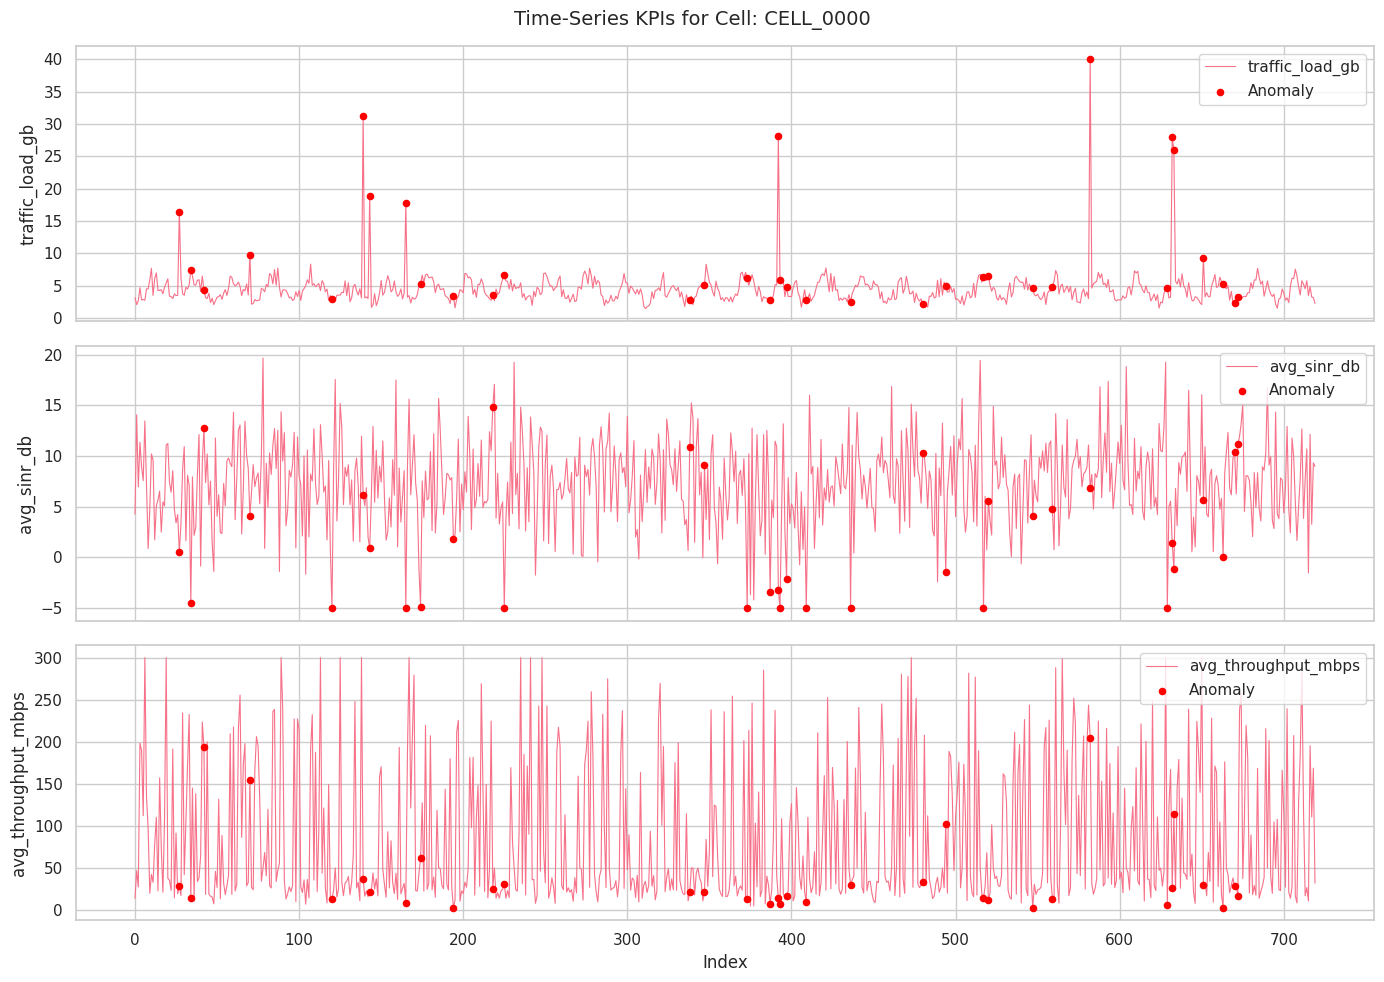

In [7]:
# Time-series plot for a sample cell
time_col = [c for c in df.columns if 'time' in c.lower() or 'date' in c.lower() or 'timestamp' in c.lower()]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
kpi_cols = [c for c in numeric_cols if c != anomaly_col]

sample_cell = df[cell_col].value_counts().index[0]
cell_data = df[df[cell_col] == sample_cell].copy()

if time_col:
    cell_data = cell_data.sort_values(time_col[0])

fig, axes = plt.subplots(min(3, len(kpi_cols)), 1, figsize=(14, 10), sharex=True)
if min(3, len(kpi_cols)) == 1:
    axes = [axes]
for i, col in enumerate(kpi_cols[:3]):
    ax = axes[i]
    ax.plot(cell_data.index, cell_data[col], linewidth=0.8, label=col)
    anomaly_mask = cell_data[anomaly_col] == 1
    ax.scatter(cell_data.index[anomaly_mask], cell_data.loc[anomaly_mask, col],
               color='red', s=20, zorder=5, label='Anomaly')
    ax.set_ylabel(col)
    ax.legend(loc='upper right')
ax.set_xlabel('Index')
fig.suptitle(f'Time-Series KPIs for Cell: {sample_cell}', fontsize=14)
plt.tight_layout()
plt.show()

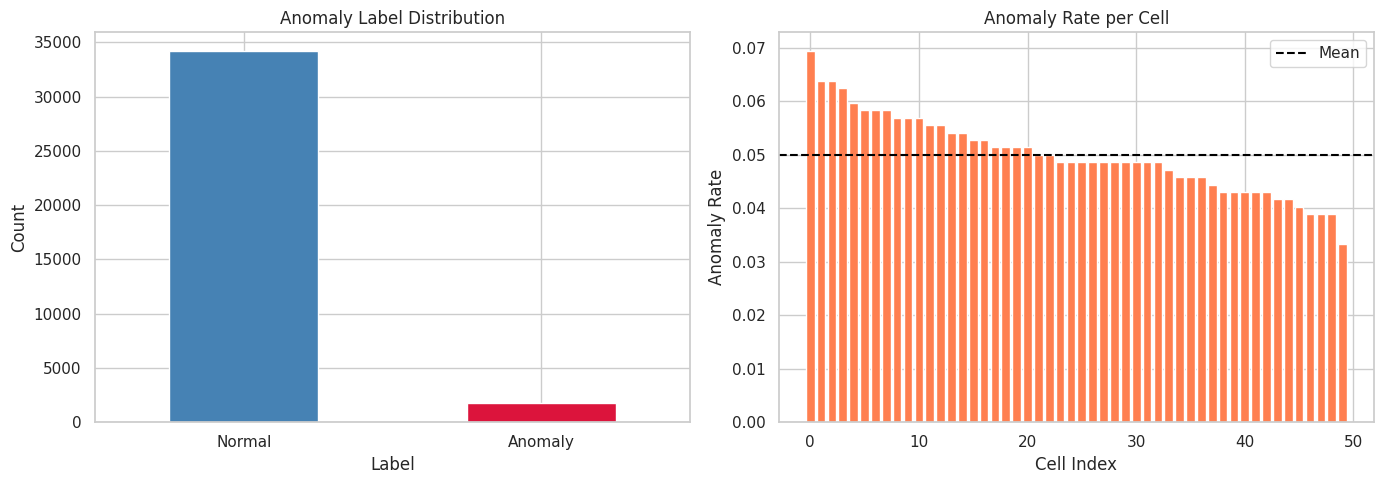

In [8]:
# Anomaly distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df[anomaly_col].value_counts().plot(kind='bar', ax=axes[0], color=['steelblue', 'crimson'])
axes[0].set_title('Anomaly Label Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Normal', 'Anomaly'], rotation=0)

# Anomaly rate per cell
cell_anomaly_rate = df.groupby(cell_col)[anomaly_col].mean().sort_values(ascending=False)
axes[1].bar(range(len(cell_anomaly_rate)), cell_anomaly_rate.values, color='coral')
axes[1].set_title('Anomaly Rate per Cell')
axes[1].set_xlabel('Cell Index')
axes[1].set_ylabel('Anomaly Rate')
axes[1].axhline(y=cell_anomaly_rate.mean(), color='black', linestyle='--', label='Mean')
axes[1].legend()

plt.tight_layout()
plt.show()

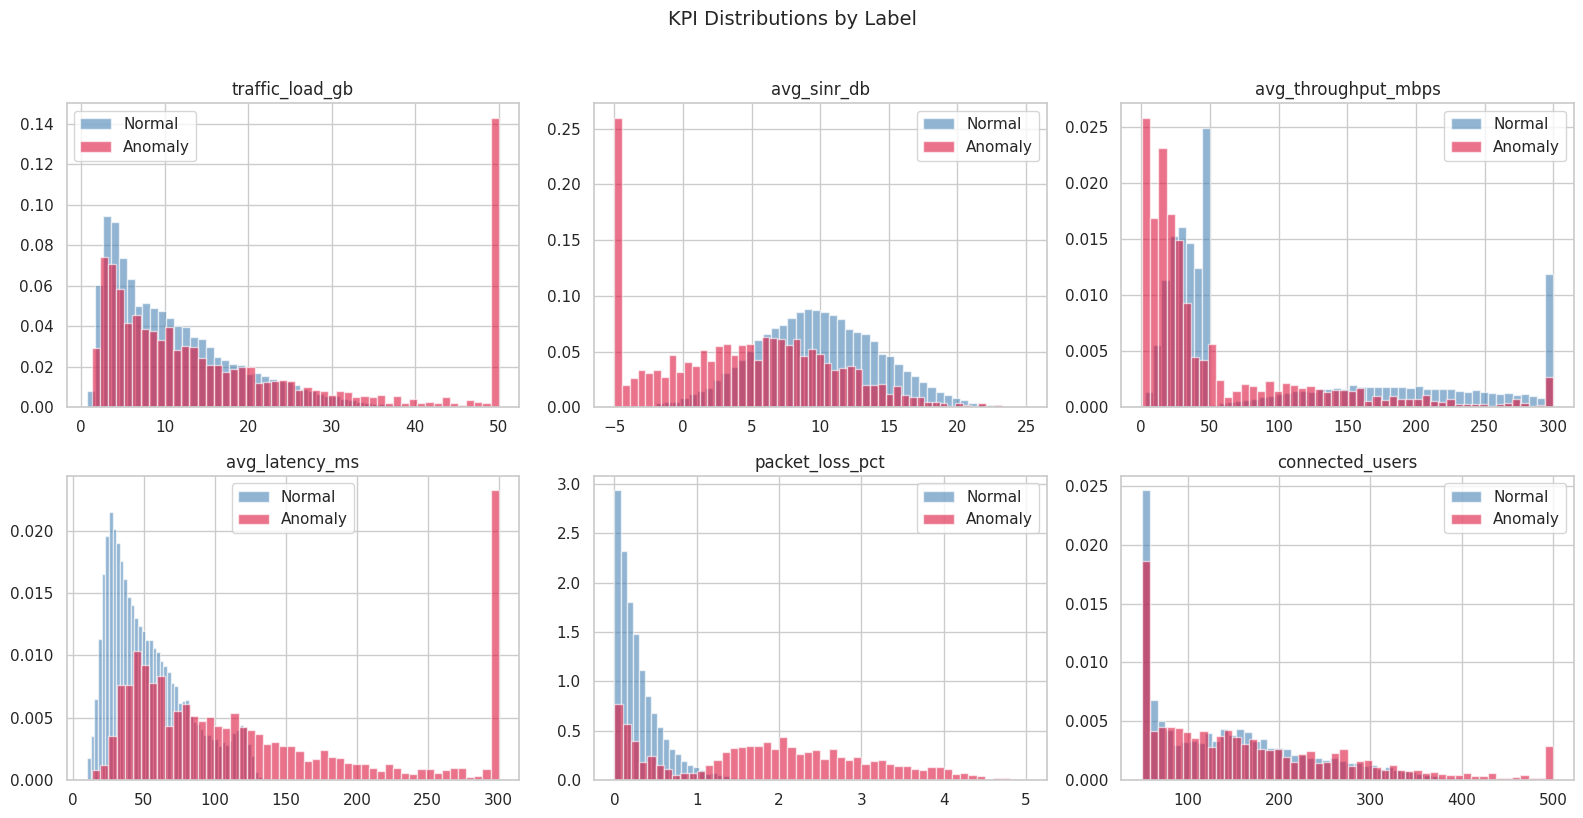

In [9]:
# KPI distributions by label (normal vs anomaly)
plot_cols = kpi_cols[:6]
n_plots = len(plot_cols)
n_rows = (n_plots + 2) // 3

fig, axes = plt.subplots(n_rows, 3, figsize=(16, 4 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_plots == 1 else axes

for i, col in enumerate(plot_cols):
    for label, color in zip([0, 1], ['steelblue', 'crimson']):
        subset = df[df[anomaly_col] == label][col]
        axes[i].hist(subset, bins=50, alpha=0.6, color=color,
                     label='Anomaly' if label == 1 else 'Normal', density=True)
    axes[i].set_title(f'{col}')
    axes[i].legend()

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('KPI Distributions by Label', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Feature Engineering

In [10]:
from anomaly_detection.features import FeatureEngineer

fe = FeatureEngineer()
df_features = fe.pipeline(df)
print(f"Feature matrix shape: {df_features.shape}")
print(f"Original columns: {len(df.columns)} -> Engineered columns: {len(df_features.columns)}")

Running feature engineering pipeline...
  ✓ Creating temporal features
  ✓ Creating interaction features
  ✓ Encoding categorical features
  ✓ Handling missing values
✓ Feature engineering complete! Shape: (36000, 24)
Feature matrix shape: (36000, 24)
Original columns: 13 -> Engineered columns: 24


In [11]:
# Inspect new features
new_cols = [c for c in df_features.columns if c not in df.columns]
print(f"New engineered features ({len(new_cols)}):")
for col in new_cols:
    print(f"  - {col}")

df_features.head()

New engineered features (13):
  - hour
  - day_of_week
  - is_weekend
  - is_peak_hour
  - load_per_user
  - spectral_efficiency
  - congestion_index
  - sinr_throughput_ratio
  - utilization_load_gap
  - cell_type_micro
  - cell_type_small
  - area_type_suburban
  - area_type_urban


,cell_id,timestamp,traffic_load_gb,avg_sinr_db,avg_throughput_mbps,avg_latency_ms,packet_loss_pct,connected_users,prb_utilization,label_anomaly,...,is_peak_hour,load_per_user,spectral_efficiency,congestion_index,sinr_throughput_ratio,utilization_load_gap,cell_type_micro,cell_type_small,area_type_suburban,area_type_urban
0,CELL_0000,2024-01-01 00:00:00,3.166556,4.278941,14.021683,22.592645,0.053849,50,0.291649,0,...,0,0.063331,1.511130,0.131783,0.305166,0.228318,False,True,False,True
1,CELL_0000,2024-01-01 01:00:00,2.068169,14.065475,47.020030,24.239901,0.313087,50,0.257246,0,...,0,0.041363,2.466240,0.124713,0.299138,0.215883,False,True,False,True
2,CELL_0000,2024-01-01 02:00:00,2.663578,6.956401,27.325802,24.779480,0.319210,50,0.159232,0,...,0,0.053272,2.285454,0.078914,0.254573,0.105960,False,True,False,True
3,CELL_0000,2024-01-01 03:00:00,4.681469,11.359690,198.284672,35.213466,0.118063,50,0.214105,0,...,0,0.093629,12.120319,0.150787,0.057290,0.120475,False,True,False,True
4,CELL_0000,2024-01-01 04:00:00,2.791156,8.947822,189.794372,24.632216,1.034568,50,0.219751,0,...,0,0.055823,13.607456,0.108259,0.047145,0.163928,False,True,False,True


In [12]:
# Prepare feature matrix (exclude label and non-numeric columns)
exclude_cols = [anomaly_col, cell_col] + time_col
feature_cols = [c for c in df_features.select_dtypes(include=[np.number]).columns if c not in exclude_cols]
X = df_features[feature_cols].copy()
y_true = df_features[anomaly_col].values

print(f"Feature matrix X: {X.shape}")
print(f"Ground truth labels y: {y_true.shape}")
print(f"Features used: {feature_cols}")

Feature matrix X: (36000, 16)
Ground truth labels y: (36000,)
Features used: ['traffic_load_gb', 'avg_sinr_db', 'avg_throughput_mbps', 'avg_latency_ms', 'packet_loss_pct', 'connected_users', 'prb_utilization', 'hour', 'day_of_week', 'is_weekend', 'is_peak_hour', 'load_per_user', 'spectral_efficiency', 'congestion_index', 'sinr_throughput_ratio', 'utilization_load_gap']


## 5. Model Training

In [13]:
from anomaly_detection.models import IsolationForestModel

model = IsolationForestModel()
print("Isolation Forest model initialized.")
print(f"Model config: {model.config}")

Isolation Forest model initialized.
Model config: {'algorithm': 'isolation_forest', 'cv_folds': 5, 'cv_strategy': 'kfold', 'hyperparameters': {'n_estimators': 200, 'max_samples': 'auto', 'contamination': 0.05, 'max_features': 1.0, 'random_state': 42}, 'early_stopping_rounds': None, 'verbose': True}


In [14]:
# Train unsupervised - no labels provided
model.train(X)
print("Model training complete (unsupervised - no labels used).")

Isolation Forest model trained successfully.
Model training complete (unsupervised - no labels used).


In [15]:
# Predict anomaly scores
anomaly_scores = model.decision_scores(X)
anomaly_preds_binary = model.predict(X)

# IsolationForestModel.predict() already returns 1 for anomaly, 0 for normal
print(f"Anomaly scores range: [{anomaly_scores.min():.4f}, {anomaly_scores.max():.4f}]")
print(f"Predicted anomalies: {anomaly_preds_binary.sum()} / {len(anomaly_preds_binary)}")
print(f"Predicted anomaly rate: {anomaly_preds_binary.mean():.4f}")

Anomaly scores range: [-0.1279, 0.1675]
Predicted anomalies: 1800 / 36000
Predicted anomaly rate: 0.0500


## 6. Evaluation & Metrics

In [16]:
from sklearn.metrics import (
    classification_report, f1_score, precision_score,
    recall_score, roc_auc_score, roc_curve, confusion_matrix
)

# Evaluate against ground truth
print("Classification Report (Isolation Forest vs Ground Truth):")
print("=" * 60)
print(classification_report(y_true, anomaly_preds_binary, target_names=['Normal', 'Anomaly']))

f1 = f1_score(y_true, anomaly_preds_binary)
precision = precision_score(y_true, anomaly_preds_binary)
recall = recall_score(y_true, anomaly_preds_binary)
print(f"F1 Score:   {f1:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")

Classification Report (Isolation Forest vs Ground Truth):
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98     34200
     Anomaly       0.70      0.70      0.70      1800

    accuracy                           0.97     36000
   macro avg       0.84      0.84      0.84     36000
weighted avg       0.97      0.97      0.97     36000

F1 Score:   0.6983
Precision:  0.6983
Recall:     0.6983


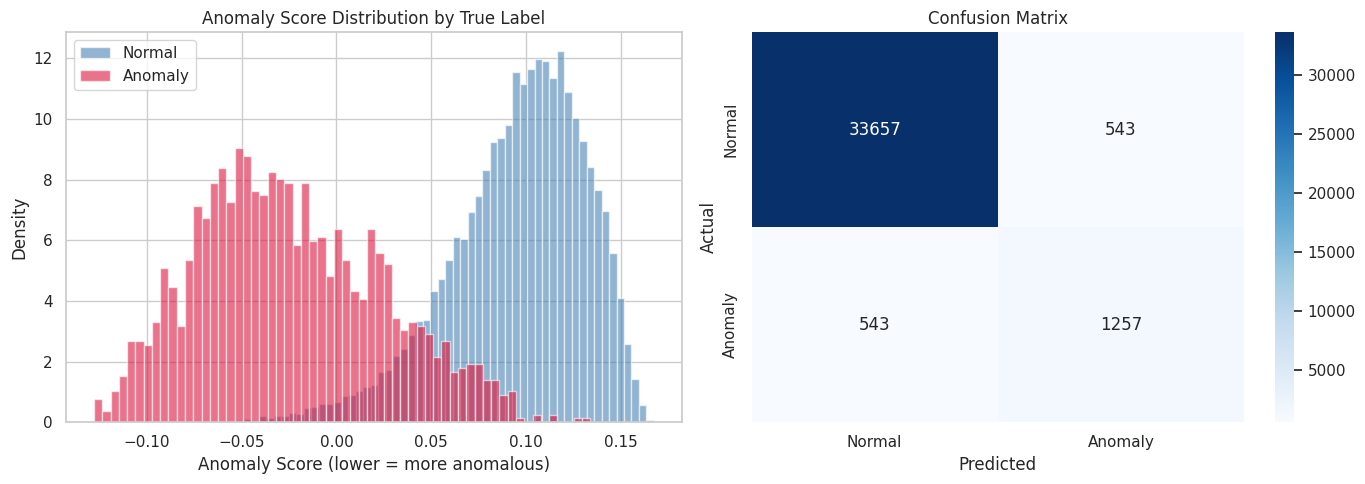

In [17]:
# Anomaly score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of anomaly scores by true label
for label, color, name in zip([0, 1], ['steelblue', 'crimson'], ['Normal', 'Anomaly']):
    mask = y_true == label
    axes[0].hist(anomaly_scores[mask], bins=60, alpha=0.6, color=color, label=name, density=True)
axes[0].set_title('Anomaly Score Distribution by True Label')
axes[0].set_xlabel('Anomaly Score (lower = more anomalous)')
axes[0].set_ylabel('Density')
axes[0].legend()

# Confusion matrix
cm = confusion_matrix(y_true, anomaly_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
axes[1].set_title('Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

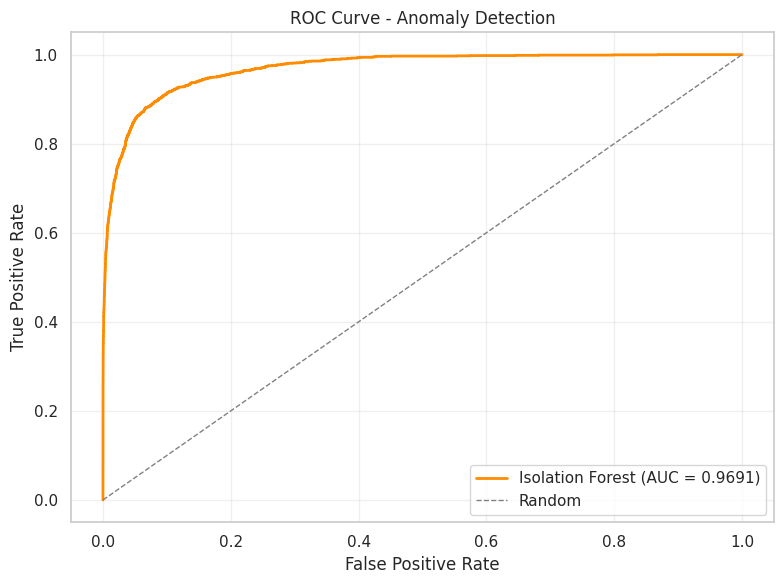

ROC AUC Score: 0.9691


In [18]:
# ROC Curve using anomaly scores
# Negate scores because lower score = more anomalous in sklearn Isolation Forest
roc_scores = -anomaly_scores
fpr, tpr, thresholds = roc_curve(y_true, roc_scores)
auc_score = roc_auc_score(y_true, roc_scores)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Isolation Forest (AUC = {auc_score:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Anomaly Detection')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"ROC AUC Score: {auc_score:.4f}")

## 7. Interpretation

In [19]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

# Custom scorer that converts IsolationForest -1/1 to 0/1 before computing F1
def isolation_forest_f1(estimator, X, y_true):
    raw_preds = estimator.predict(X)
    binary_preds = (raw_preds == -1).astype(int)
    return f1_score(y_true, binary_preds)

# Permutation importance using the underlying sklearn Isolation Forest model
perm_result = permutation_importance(
    model.model, X, y_true,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring=isolation_forest_f1
)

perm_df = pd.DataFrame({
    'feature': feature_cols,
    'importance_mean': perm_result.importances_mean,
    'importance_std': perm_result.importances_std
}).sort_values('importance_mean', ascending=False)

print("Feature Importance (Permutation):")
print(perm_df.head(15).to_string(index=False))

Feature Importance (Permutation):
              feature  importance_mean  importance_std
      packet_loss_pct         0.112425        0.002108
  spectral_efficiency         0.072951        0.002084
sinr_throughput_ratio         0.060433        0.001568
 utilization_load_gap         0.046183        0.001806
          avg_sinr_db         0.046101        0.002027
        load_per_user         0.039993        0.002087
                 hour         0.025231        0.001912
     congestion_index         0.025080        0.002888
       avg_latency_ms         0.024166        0.002548
           is_weekend         0.007465        0.004269
      traffic_load_gb         0.005749        0.003399
          day_of_week        -0.001355        0.002803
  avg_throughput_mbps        -0.007217        0.002553
         is_peak_hour        -0.026764        0.002461
      prb_utilization        -0.030616        0.003017


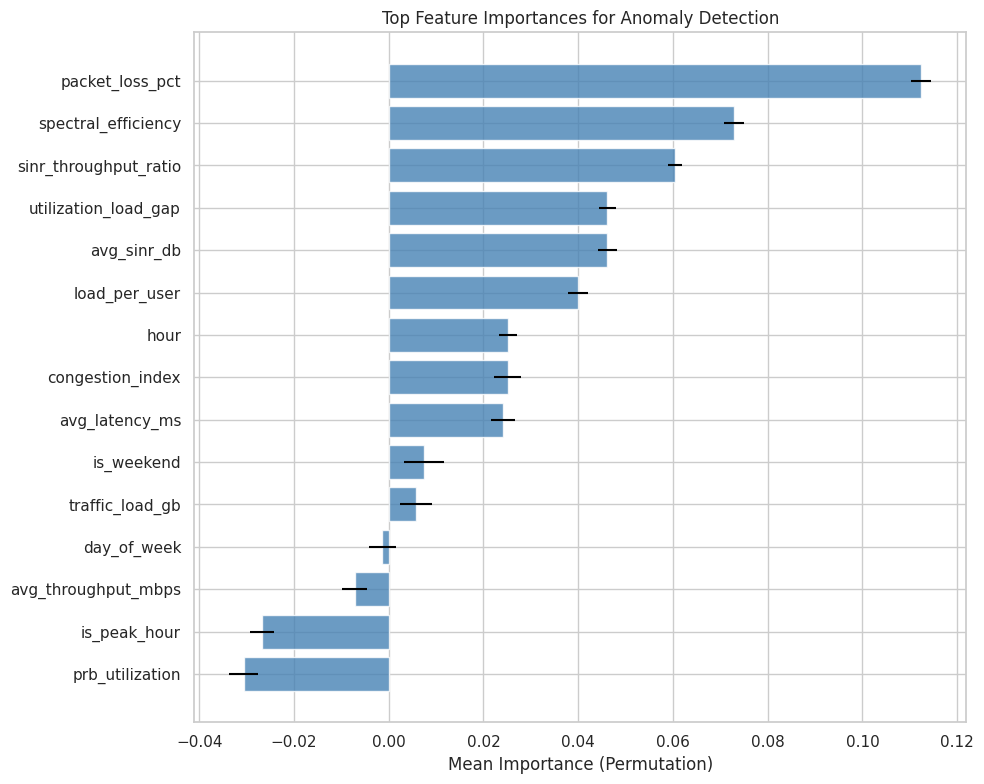

In [20]:
# Plot feature importance
top_n = min(15, len(perm_df))
top_features = perm_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(range(top_n), top_features['importance_mean'].values,
        xerr=top_features['importance_std'].values,
        color='steelblue', alpha=0.8)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Mean Importance (Permutation)')
ax.set_title('Top Feature Importances for Anomaly Detection')

plt.tight_layout()
plt.show()

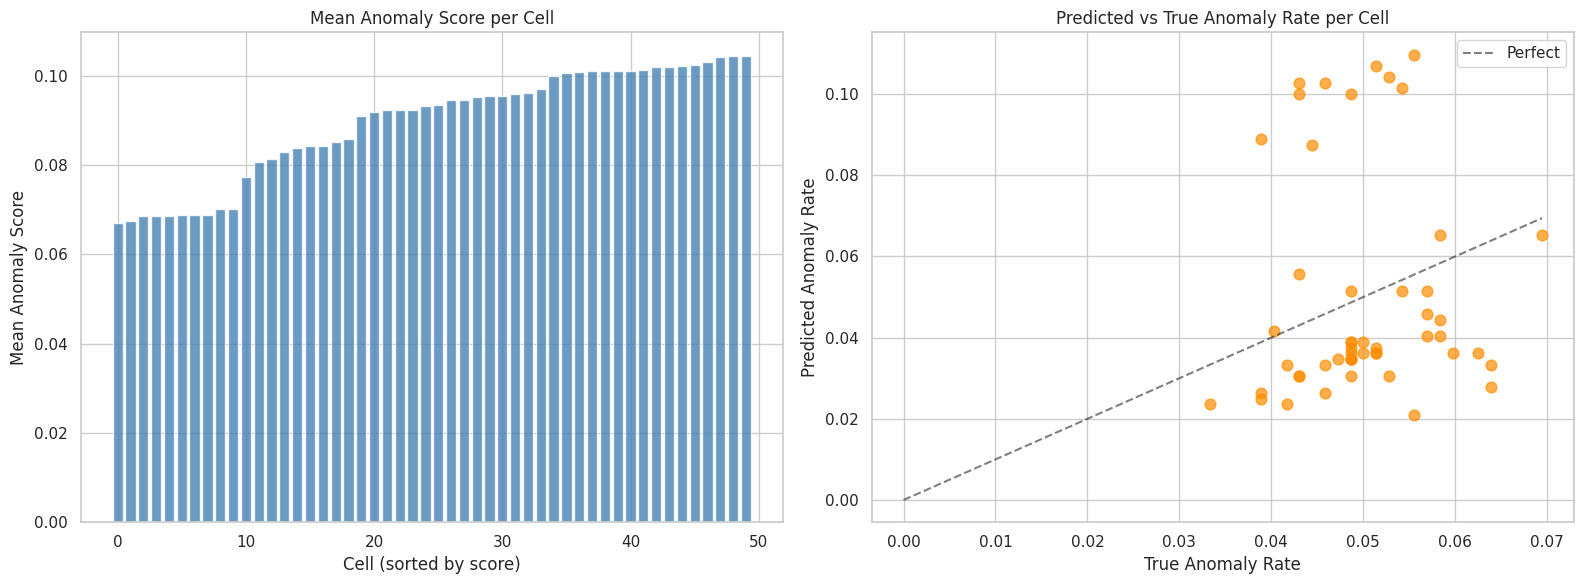

In [21]:
# Anomaly score visualization across cells
df_features['anomaly_score'] = anomaly_scores
df_features['predicted_anomaly'] = anomaly_preds_binary

cell_scores = df_features.groupby(cell_col).agg(
    mean_score=('anomaly_score', 'mean'),
    min_score=('anomaly_score', 'min'),
    anomaly_rate=('predicted_anomaly', 'mean'),
    true_anomaly_rate=(anomaly_col, 'mean')
).sort_values('mean_score')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mean anomaly score per cell
colors = ['crimson' if rate > 0.1 else 'steelblue' for rate in cell_scores['true_anomaly_rate']]
axes[0].bar(range(len(cell_scores)), cell_scores['mean_score'], color=colors, alpha=0.8)
axes[0].set_title('Mean Anomaly Score per Cell')
axes[0].set_xlabel('Cell (sorted by score)')
axes[0].set_ylabel('Mean Anomaly Score')

# Predicted vs true anomaly rate per cell
axes[1].scatter(cell_scores['true_anomaly_rate'], cell_scores['anomaly_rate'],
                alpha=0.7, s=60, color='darkorange')
axes[1].plot([0, cell_scores['true_anomaly_rate'].max()],
             [0, cell_scores['true_anomaly_rate'].max()],
             'k--', alpha=0.5, label='Perfect')
axes[1].set_xlabel('True Anomaly Rate')
axes[1].set_ylabel('Predicted Anomaly Rate')
axes[1].set_title('Predicted vs True Anomaly Rate per Cell')
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Business Insights & Conclusions

In [22]:
# Threshold sensitivity analysis for early warning
thresholds_to_test = np.percentile(anomaly_scores, [1, 2, 5, 10, 15, 20])

print("Threshold Tuning Analysis:")
print("=" * 70)
print(f"{'Percentile':>12} {'Threshold':>12} {'Precision':>12} {'Recall':>12} {'F1':>12}")
print("-" * 70)

results = []
for pct, thr in zip([1, 2, 5, 10, 15, 20], thresholds_to_test):
    preds = (anomaly_scores < thr).astype(int)
    if preds.sum() > 0:
        p = precision_score(y_true, preds, zero_division=0)
        r = recall_score(y_true, preds, zero_division=0)
        f = f1_score(y_true, preds, zero_division=0)
    else:
        p, r, f = 0, 0, 0
    results.append({'percentile': pct, 'threshold': thr, 'precision': p, 'recall': r, 'f1': f})
    print(f"{pct:>12}th {thr:>12.4f} {p:>12.4f} {r:>12.4f} {f:>12.4f}")

results_df = pd.DataFrame(results)

Threshold Tuning Analysis:
  Percentile    Threshold    Precision       Recall           F1
----------------------------------------------------------------------
           1th      -0.0675       0.9972       0.1994       0.3324
           2th      -0.0453       0.9542       0.3817       0.5452
           5th       0.0000       0.6983       0.6983       0.6983
          10th       0.0336       0.4342       0.8683       0.5789
          15th       0.0501       0.3067       0.9200       0.4600
          20th       0.0608       0.2364       0.9456       0.3782


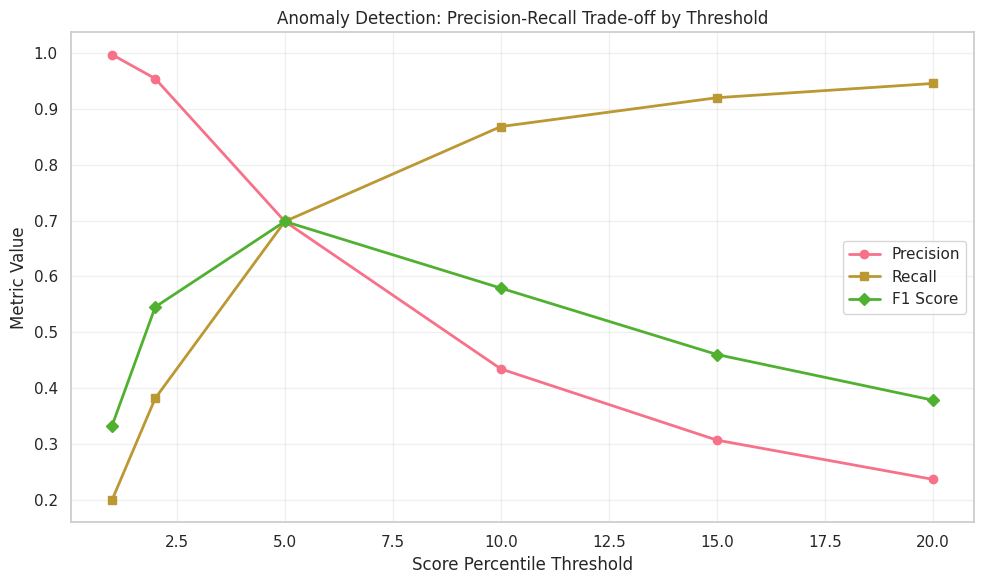

In [23]:
# Visualize threshold trade-offs
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results_df['percentile'], results_df['precision'], 'o-', label='Precision', linewidth=2)
ax.plot(results_df['percentile'], results_df['recall'], 's-', label='Recall', linewidth=2)
ax.plot(results_df['percentile'], results_df['f1'], 'D-', label='F1 Score', linewidth=2)
ax.set_xlabel('Score Percentile Threshold')
ax.set_ylabel('Metric Value')
ax.set_title('Anomaly Detection: Precision-Recall Trade-off by Threshold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Early warning: time-to-detection analysis
print("Early Warning System Insights:")
print("=" * 60)
print(f"")
print(f"Model Performance Summary:")
print(f"  - ROC AUC: {auc_score:.4f}")
print(f"  - Default F1: {f1:.4f} (Precision: {precision:.4f}, Recall: {recall:.4f})")
print(f"")
print(f"Key Findings:")
print(f"  - The Isolation Forest identifies anomalies without requiring labeled data,")
print(f"    making it suitable for real-time deployment where labels are unavailable.")
print(f"  - Top contributing features suggest monitoring these KPIs for early warning.")
print(f"  - Cell-level analysis reveals some cells are more prone to anomalies,")
print(f"    indicating potential infrastructure or coverage issues.")
print(f"")
print(f"Recommendations:")
print(f"  1. Deploy with conservative threshold (high recall) for safety-critical alerts.")
print(f"  2. Use tiered alerting: high-confidence anomalies trigger immediate action,")
print(f"     borderline cases flagged for human review.")
print(f"  3. Retrain periodically as network patterns evolve seasonally.")
print(f"  4. Focus monitoring on top features identified by permutation importance.")
print(f"  5. Investigate cells with consistently high anomaly scores for root-cause analysis.")

Early Warning System Insights:

Model Performance Summary:
  - ROC AUC: 0.9691
  - Default F1: 0.6983 (Precision: 0.6983, Recall: 0.6983)

Key Findings:
  - The Isolation Forest identifies anomalies without requiring labeled data,
    making it suitable for real-time deployment where labels are unavailable.
  - Top contributing features suggest monitoring these KPIs for early warning.
  - Cell-level analysis reveals some cells are more prone to anomalies,
    indicating potential infrastructure or coverage issues.

Recommendations:
  1. Deploy with conservative threshold (high recall) for safety-critical alerts.
  2. Use tiered alerting: high-confidence anomalies trigger immediate action,
     borderline cases flagged for human review.
  3. Retrain periodically as network patterns evolve seasonally.
  4. Focus monitoring on top features identified by permutation importance.
  5. Investigate cells with consistently high anomaly scores for root-cause analysis.


### Summary

This notebook demonstrated an unsupervised anomaly detection pipeline for telecom network data:

- **Data**: Loaded and validated synthetic network KPI data with ground-truth anomaly labels.
- **EDA**: Explored time-series behavior, anomaly distributions, and KPI patterns.
- **Features**: Applied feature engineering to enrich the raw KPI signals.
- **Model**: Trained an Isolation Forest in a fully unsupervised manner (no labels used during training).
- **Evaluation**: Assessed detection quality against ground truth using F1, precision, recall, and ROC AUC.
- **Interpretation**: Identified key features driving anomaly detection and analyzed cell-level patterns.
- **Business Value**: Threshold tuning enables early warning systems with configurable precision-recall trade-offs.